In [1]:
pip install pytorch-msssim

In [2]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import os
#import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as Functional
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import shutil
from torchvision.utils import save_image

In [3]:
testfolder = '/content/test'
Dir  = '/content/ImageNet'
Dir2  = '/content/ImageNet2'
DirImages='/content/ImageNet/ILSVRC/Data/DET'
DirtestImages='/content/ImageNet2/ILSVRC/Data/DET'
Dirtestimages2 = '/content/Testimages'
# modelsavepath = os.path.join('/content/','modelParameters/') #create
# modelsavepath15 = os.path.join('/content/','modelParameters15/') 
# modelsavepath5 = os.path.join('/content/','modelParameters5/') 
modelpath = os.path.join('/content/','modelParameters25.0/','20.pth') # specify the path you placed the model weights
Dirtestimages2 = '/content/Testimages'

In [ ]:
if os.path.exists(Dir):
  print("Path exists, not creating folders")
else:
    os.mkdir(Dirtestimages2)
    os.mkdir(os.path.join(Dirtestimages2,'Test'))
    os.mkdir(Dir)
    os.chdir(Dir)
    !wget https://image-net.org/data/ILSVRC/2016/ILSVRC2016_DET_test_new.tar.gz
    os.chdir(Dir)
    !gunzip ILSVRC2016_DET_test_new.tar.gz
    !tar -xvf ILSVRC2016_DET_test_new.tar
    os.mkdir(Dir2)
    os.chdir(Dir2)
    !wget https://image-net.org/data/ILSVRC/2017/ILSVRC2017_DET_test_new.tar.gz
    os.chdir(Dir2)
    !gunzip ILSVRC2017_DET_test_new.tar.gz
    !tar -xvf ILSVRC2017_DET_test_new.tar
    os.chdir(DirImages)

In [5]:
temp2 = os.path.join(Dir2,'ILSVRC/Data/DET/test')
temp1 = os.path.join(Dir,'ILSVRC/Data/DET/test')
j=0
for i in os.listdir(temp2):
  j=j+1
  source = os.path.join(temp2,i)
  destination = os.path.join(temp1,i)
  shutil.move(source, destination)
  if j==4000:
    break
  

In [6]:
transform1 =Compose([
    Resize(size=(64,64)),
    ToTensor()
])

In [7]:
class ImageDataset(Dataset):
  def __init__(self,dataset1,maskpercentage):
    k = round(64*64*maskpercentage)
    size = (len(dataset1),k*3)
    size1 = (len(dataset1),k)
    mask= torch.zeros(size=(64*64,))
    self.image = torch.zeros(size = size)
    self.masks = torch.zeros(size =size1)
    self.no = torch.zeros(size = (len(dataset1),)) 
    for i in range(len(dataset1)):
     ri = np.sort(np.random.choice(64*64, k, replace=False))
    #  print(ri)
     x = torch.flatten(dataset1[i][0])
     x= torch.stack((x[ri],x[64*64 + ri],x[2*64*64 + ri]))
     mask[ri]=1
     self.image[i] = torch.flatten(x)
     self.masks[i]=torch.from_numpy(ri)
     self.no[i] =dataset1[i][1]
     
  def __len__(self):
        return len(self.no)
  def __getitem__(self, idx):
    return self.image[idx].numpy(),self.masks[idx].numpy(), self.no[idx].numpy()




In [8]:
class CS(Dataset):
  def __init__(self,sampled_image,mask,dataset1):
    # a = torch.unsqueeze(dataset1[0][0],0)
    # print(a.shape)
    # for i in range(1,len(dataset1)):
      
    #   b=torch.unsqueeze(dataset1[i][0],0)
    #   print(i)
    #   a = torch.cat((a,b),0)
    # self.real_image = a 
    self.inputimage = torch.cat((sampled_image,mask),dim=1)
    self.no = torch.tensor(range(0,len(dataset1)))
    
  def __len__(self):
      return self.inputimage.shape[0]
  
  def __getitem__(self, idx):
    return self.inputimage[idx],self.no[idx]


In [9]:
class AE(nn.Module):
  def __init__(self):
    super(AE,self).__init__()
    in_c = 3


    self.convup = nn.Sequential( nn.Conv2d(4,8 , kernel_size = 3, stride =1, padding = 'same', bias = False),
			nn.BatchNorm2d(8),
			nn.LeakyReLU(inplace = True),
      nn.Conv2d(8,9, kernel_size = 3, stride =1, padding = 'same', bias = False),
			nn.BatchNorm2d(9),
			nn.LeakyReLU(inplace = True),
     nn.Conv2d(9,in_c , kernel_size = 3, stride =1, padding = 'same', bias = False),
			nn.BatchNorm2d(in_c),
			nn.LeakyReLU(inplace = True),
      nn.Conv2d(in_c,in_c , kernel_size = 3, stride =1, padding = 'same', bias = False),
			nn.BatchNorm2d(in_c),
			nn.LeakyReLU(inplace = True)
    )
    self.convup1 = nn.Sequential( nn.Conv2d(6,in_c , kernel_size = 3, stride =1, padding = 'same', bias = False),
			nn.BatchNorm2d(in_c),
			nn.ReLU(inplace = True),
      nn.Conv2d(in_c,in_c , kernel_size = 3, stride =1, padding = 'same', bias = False),
			nn.BatchNorm2d(in_c),
			nn.LeakyReLU(inplace = True))


  def forward(self,image):
   #encoder
   B = image.shape[0]
   sampled=image[:,0:3]
   x4 = self.convup(image)


   return x4
   

  

In [10]:
def trainmodel(B,dataset1,dataset2,num_epochs,modelsave):
  learning_rate=1e-2
  ssimLR = 1e-1
  msLR = 0
  if torch.cuda.is_available():
   device = torch.device('cuda:0')

  else:
    device = torch.device('cpu')

  device2 = torch.device('cpu')

  dataloader1 = DataLoader(dataset = dataset1, batch_size= B,num_workers=1,pin_memory=True)
  dataloader2 = DataLoader(dataset = dataset2, batch_size= B,num_workers=1,pin_memory=True)
  
  total_samples = len(dataset1)
  model= AE()
  Mseloss = nn.MSELoss() #loss  function
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
 # torch.backends.cudnn.deterministic= True

  for epochs in range(num_epochs):
    epoch_loss =0;
    Rssim = 0
    Gssim = 0
    Bssim = 0
    MSE_loss=0
    training_batch1 = iter(dataloader1)
    training_batch2= iter(dataloader2)
    for i in range(len(dataloader1)):
      OrgImages,clas = next(training_batch1)
      images,clas= next(training_batch2)
      images = images.to(device,dtype =torch.float32)
      OrgImages = OrgImages.to(device,dtype=torch.float32)

      Reconstructed=model(images)
      Rssim = Rssim+ssim(Reconstructed[:,0:1],images[:,0:1])
      Gssim = Rssim+ssim(Reconstructed[:,1:2],images[:,1:2])
      Bssim = Rssim+ssim(Reconstructed[:,2:3],images[:,2:3])

      L2_loss =ssimLR* (1 - ssim( Reconstructed, OrgImages, data_range=1, size_average=True))+msLR*Mseloss( Reconstructed, OrgImages)
      MSE_loss =MSE_loss+ Mseloss( Reconstructed, OrgImages)
      batch_loss = L2_loss
      epoch_loss = epoch_loss + batch_loss
      model.train()
      batch_loss = batch_loss.to(dtype = torch.float32)
      batch_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    print("epochloss", epoch_loss)
    # print("Red channel ssim ",Rssim/len(dataset1))
    # print("Green channel ssim ",Gssim/len(dataset1))
    # print("Blue channel ssim ",Bssim/len(dataset1))
    print("MSE loss: " ,MSE_loss)
    if (epochs+1) % 2 ==0:
     path1 = os.path.join(modelsave, str(epochs+1)+'.pth')
     print(path1)
     torch.save(model.state_dict(), path1)


      




In [11]:
def trypredict(images,path):
  device2 = torch.device('cpu')
  #run after training
  loaded_model = AE()
  loaded_model.load_state_dict(torch.load(path,map_location = device2))
  loaded_model.eval();
  images = images.to(device2,dtype = torch.float32)
 # OrgImages=OrgImages.to(device2,dtype = torch.float32)
  
  Reconstructed=loaded_model(images)
  Reconstructed = Reconstructed.detach()
  return Reconstructed

In [12]:
def plot(Reconstructed,OrgImages,Sentimages):
    fig = plt.figure(figsize=(10, 10))
    for i in range(OrgImages.shape[0]):
        im = torch.permute(OrgImages[i],(1,2,0))
        RC= torch.permute(Reconstructed[i],(1,2,0))
        # sent = Sentimages[i][0:2]
        # masks = Sentimages[i][2:3]
        sent = torch.permute(Sentimages[i][0:3],(1,2,0))
        #masks = torch.permute(Sentimages[i][3],(1,2,0))
        masks = Sentimages[i][3]

        fig.add_subplot(i+1,4,1)
        plt.imshow(sent)
        fig.add_subplot(i+1,4,2)
        plt.imshow(masks,cmap='gray')
        
        fig.add_subplot(i+1,4,3)
        plt.imshow(RC)
        fig.add_subplot(i+1,4,4)
        plt.imshow(im)
        plt.show()

In [13]:
dataset1 = datasets.ImageFolder(DirImages, transform=transform1)

## Run all the above until here for testing


In [ ]:
Imagepercentagelist = [0.25,0.15,0.05]
for per in Imagepercentagelist:

  Imagepercentage = per
  d = ImageDataset(dataset1,Imagepercentage)
  im = np.zeros((len(d),3,64*64))
  mask = np.zeros((len(d),1,64*64))

  k = round(64*64*Imagepercentage)
  for ind in range(0,len(d)):
    # print(ind)
    j=0
    for i in d[ind][1]:
      i = int(i)
      im[ind,0,i] = d[ind][0][j]
      im[ind,1,i] = d[ind][0][k+j]
      im[ind,2,i] = d[ind][0][2*k+j]
      mask[ind, 0,i] = 1
      j=j+1
  im= np.reshape(im,(len(d),3,64,64))
  mask= np.reshape(mask,(len(d),1,64,64))
  mask= torch.from_numpy(mask)
  sampled_image = torch.from_numpy(im)
  ds = CS(sampled_image,mask,dataset1)
  modelpath = os.path.join('/content', 'modelParameters'+str(Imagepercentage*100))
  if os.path.exists(modelpath):
    shutil.rmtree(modelpath)
  os.mkdir(modelpath)
  trainmodel(45,dataset1,ds,40,modelpath )


In [83]:
import PIL

In [36]:
Imagepercentagelist = [0.25,0.15,0.05]
testpercentagelist = [0.05,0.10,0.15,0.20,0.25,0.40]
ssimlist= []
for per in Imagepercentagelist:
  modelpath = os.path.join('/content', 'modelParameters'+str(per*100),'20.pth')
  metriclist=[]
  for testper in testpercentagelist:
    testdataset = datasets.ImageFolder(DirtestImages, transform=transform1)
    test1 = ImageDataset(testdataset,testper)
    im1 = np.zeros((len(test1),3,64*64))
    mask1 = np.zeros((len(test1),1,64*64))
    k = round(64*64*testper)

    for ind in range(0,len(test1)):
       j=0
       for i in test1[ind][1]:
          i = int(i)
          im1[ind,0,i] = test1[ind][0][j]
          im1[ind,1,i] = test1[ind][0][k+j]
          im1[ind,2,i] = test1[ind][0][2*k+j]
          mask1[ind, 0,i] = 1
          j=j+1
    im1= np.reshape(im1,(len(test1),3,64,64))
    mask1= np.reshape(mask1,(len(test1),1,64,64))
    mask1= torch.from_numpy(mask1)
    sampled_image1 = torch.from_numpy(im1)
    ds1 = CS(sampled_image1,mask1,testdataset)

    ssimMetric = 0
    for i in range(len(testdataset)):
      OrgTestImages,clas = testdataset[i]
      test_images,clas =ds1[i]
      OrgTestImages = torch.unsqueeze(OrgTestImages,0)
      test_images = torch.unsqueeze(test_images,0)
      Reconstructed=trypredict(test_images,modelpath)
      ssimMetric = ssimMetric + ssim(Reconstructed,OrgTestImages)
    ssimMetric = ssimMetric/len(testdataset)
    print('SSIM Metric in Testdataset is :',ssimMetric )
    metriclist.append(ssimMetric)
  ssimlist.append(metriclist) 



SSIM Metric in Testdataset is : tensor(0.9974)
SSIM Metric in Testdataset is : tensor(0.9990)
SSIM Metric in Testdataset is : tensor(0.9994)
SSIM Metric in Testdataset is : tensor(0.9995)
SSIM Metric in Testdataset is : tensor(0.9996)
SSIM Metric in Testdataset is : tensor(0.9997)
SSIM Metric in Testdataset is : tensor(0.9976)
SSIM Metric in Testdataset is : tensor(0.9985)
SSIM Metric in Testdataset is : tensor(0.9987)
SSIM Metric in Testdataset is : tensor(0.9988)
SSIM Metric in Testdataset is : tensor(0.9988)
SSIM Metric in Testdataset is : tensor(0.9987)
SSIM Metric in Testdataset is : tensor(0.9986)
SSIM Metric in Testdataset is : tensor(0.9992)
SSIM Metric in Testdataset is : tensor(0.9993)
SSIM Metric in Testdataset is : tensor(0.9993)
SSIM Metric in Testdataset is : tensor(0.9993)
SSIM Metric in Testdataset is : tensor(0.9989)


In [ ]:
#plot
plt.figure()
for i in range(0,len(Imagepercentagelist)):

  t =[]
  for s in testpercentagelist:
    t.append(s*100)
  l = 'Trained at '+ str(Imagepercentagelist[i]*100)
  plt.plot(t,ssimlist[i],label =l,marker='o' )
  plt.title('Model - SSIM vs Image Percentage')
  plt.xlabel('ImagePercentage')
  plt.ylabel('SSIM')
  plt.legend()
#im.show()

In [84]:
transform2 =Compose([
    Resize(size=(32,32),interpolation=PIL.Image.NEAREST),
    Resize(size=(64,64),interpolation=PIL.Image.NEAREST),
    ToTensor()
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [86]:
transform3 =Compose([
    Resize(size=(24,24),interpolation=PIL.Image.NEAREST),
    Resize(size=(64,64),interpolation=PIL.Image.NEAREST),
    ToTensor()
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [87]:
transform4 =Compose([
    Resize(size=(14,14),interpolation=PIL.Image.NEAREST),
    Resize(size=(64,64),interpolation=PIL.Image.NEAREST),
    ToTensor()
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [79]:
org= datasets.ImageFolder(DirtestImages, transform=transform1)

In [85]:
downsampled1= datasets.ImageFolder(DirtestImages, transform=transform2)
L=0
for i in range(len(org)):
    L= L+ssim(torch.unsqueeze(org[i][0],0),torch.unsqueeze(downsampled1[i][0],0))
print("SSIM of upscaled image with 25% of orginal size is : ",L/1500)

SSIM of upscaled image with 25% of orginal size is :  tensor(0.9995)


In [88]:
downsampled1= datasets.ImageFolder(DirtestImages, transform=transform3)
L=0
for i in range(len(org)):
    L= L+ssim(torch.unsqueeze(org[i][0],0),torch.unsqueeze(downsampled1[i][0],0))
print("SSIM of upscaled image with 15% of orginal size is : ",L/1500)

SSIM of upscaled image with 15% of orginal size is :  tensor(0.9992)


In [89]:
downsampled1= datasets.ImageFolder(DirtestImages, transform=transform4)
L=0
for i in range(len(org)):
    L= L+ssim(torch.unsqueeze(org[i][0],0),torch.unsqueeze(downsampled1[i][0],0))
print("SSIM of upscaled image with 5% of orginal size ",L/1500)

SSIM of upscaled image with 5% of orginal size  tensor(0.9984)


## Test your own Images


In [ ]:
print("please upload images in ",Dirtestimages2)


In [19]:
if os.path.exists('/content/modelParameters25.0'):
  print("Path exists, not creating folders")
else:
  os.mkdir('/content/modelParameters25.0')
  print("Upload Model path file for 25")

if os.path.exists('/content/modelParameters15.0'):
  print("Path exists, not creating folders")
else:
  os.mkdir('/content/modelParameters15.0')
  print("Upload Model path file for 15")

if os.path.exists('/content/modelParameters5.0'):
  print("Path exists, not creating folders")
else:
  os.mkdir('/content/modelParameters5.0')
  print("Upload Model path file for 5")

Path exists, not creating folders
Path exists, not creating folders
Path exists, not creating folders


In [ ]:
os.chdir('/content/')
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models


In [18]:
imagesavepath = '/content/Real-ESRGAN/inputs'
shutil.rmtree(imagesavepath)
os.mkdir(imagesavepath)
if os.path.exists('/content/Real-ESRGAN/results'):
    shutil.rmtree('/content/Real-ESRGAN/results')
os.mkdir('/content/Real-ESRGAN/results')

In [25]:
if os.path.exists(Dirtestimages2+'/.ipynb_checkpoints'):
  shutil.rmtree(Dirtestimages2+'/.ipynb_checkpoints')


In [26]:
imagepercentage = 0.25
testdataset2 = datasets.ImageFolder(Dirtestimages2, transform=transform1)
test2 = ImageDataset(testdataset2,imagepercentage)
im2 = np.zeros((len(test2),3,64*64))
mask2 = np.zeros((len(test2),1,64*64))

In [27]:
k=round(64*64*imagepercentage)
for ind in range(0,len(test2)):
  # print(ind)
  j=0
  for i in test2[ind][1]:
    i = int(i)
    im2[ind,0,i] = test2[ind][0][j]
    im2[ind,1,i] = test2[ind][0][k+j]
    im2[ind,2,i] = test2[ind][0][2*k+j]
    mask2[ind, 0,i] = 1
    j=j+1
im2= np.reshape(im2,(len(test2),3,64,64))
mask2= np.reshape(mask2,(len(test2),1,64,64))
mask2= torch.from_numpy(mask2)
sampled_image2 = torch.from_numpy(im2)
ds2 = CS(sampled_image2,mask2,testdataset2)


In [28]:
def plot(Reconstructed,OrgImages,Sentimages):
    fig = plt.figure(figsize=(10, 10))
    for i in range(OrgImages.shape[0]):
        im = torch.permute(OrgImages[i],(1,2,0))
        RC= torch.permute(Reconstructed[i],(1,2,0))
        sent = torch.permute(Sentimages[i][0:3],(1,2,0))
        masks = Sentimages[i][3]

        fig, ax = plt.subplots(1, 4)

        #fig.add_subplot(i+1,4,1)
        ax[0].set_title('Sampled')
        ax[0].imshow(sent)


       
       # fig.add_subplot(i+1,4,2)
        ax[1].imshow(masks,cmap='gray')
        ax[1].set_title('Mask')

        #fig.add_subplot(i+1,4,3)
        ax[2].imshow(RC)
        ax[2].set_title('ConvCS')

        #fig.add_subplot(i+1,4,4)
        ax[3].imshow(im)
        ax[3].set_title('Original')
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 720x720 with 0 Axes>

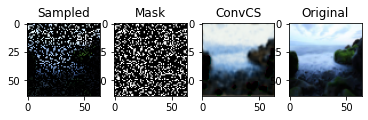

SSIM Metric in Test Images are : tensor(0.9998)


In [29]:
ssimMetric = 0
for i in range(len(testdataset2)):
  OrgTestImages,clas = testdataset2[i]
  test_images,clas =ds2[i]
  OrgTestImages = torch.unsqueeze(OrgTestImages,0)
  test_images = torch.unsqueeze(test_images,0)
  Reconstructed=trypredict(test_images,modelpath)
  a= test_images[:,0:3]
  # a=torch.tensor(a,dtype=torch.float32)
  # print(OrgTestImages.dtype)
  ssimMetric = ssimMetric + ssim(Reconstructed,OrgTestImages)
  plot(Reconstructed,OrgTestImages,test_images)
  save_image(Reconstructed,'/content/Real-ESRGAN/inputs'+'/'+str(i)+'.jpg')
ssimMetric = ssimMetric/len(testdataset2)
print('SSIM Metric in Test Images are :',ssimMetric )

In [30]:
os.chdir('/content/Real-ESRGAN')

Super Resolution


In [34]:
!python inference_realesrgan.py -n RealESRGAN_x4plus -i inputs --outscale 2.0

Testing 0 0


In [32]:
def plotim(path):
  plt.figure()
  im= plt.imread(path)
  plt.title(im.shape)
  plt.imshow(im)


you can download the images from path :/content/Real-ESRGAN/results
Super resolution, Height and Width scaled 2 times


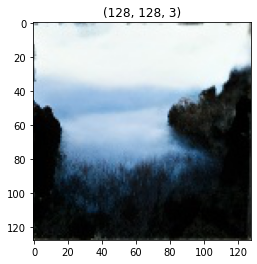

In [33]:
print("you can download the images from path :/content/Real-ESRGAN/results")
print("Super resolution, Height and Width scaled 2 times")
for i in os.listdir('/content/Real-ESRGAN/results'):
  path = '/content/Real-ESRGAN/results/'+str(i)
  plotim(path)